# Проект: Классификация поражённых растений

## Импорты библиотек


In [35]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau

import time
import copy
from tqdm.notebook import tqdm

plt.style.use('dark_background')

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используем устройство: {device}")

Используем устройство: cuda


## Подготовка данных

Определим пути к нашим данным

In [8]:
base_dir = './content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/'
train_dir = base_dir + 'train'
valid_dir = base_dir + 'valid'

Определяем трансформации

In [9]:
# Трансформации для обучающей выборки (с аугментацией)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.RandomHorizontalFlip(),   
    transforms.RandomRotation(15),      
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),  # Уменьшили hue с 0.1 до 0.05 для избежания OverflowError
    transforms.ToTensor(),               
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Трансформации для валидационной выборки (без аугментации)
valid_transforms = transforms.Compose([
    transforms.Resize(256),             
    transforms.CenterCrop(224),          
    transforms.ToTensor(),               
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

Создаем датасеты с помощью ImageFolder

In [10]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transforms)

Создаём загрузчики данных

In [14]:
batch_size = 32
# Используем num_workers=0 для Windows, чтобы избежать проблем с многопроцессной загрузкой
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

print(f"Количество обучающих изображений: {len(train_dataset)}")
print(f"Количество валидационных изображений: {len(valid_dataset)}")
print(f"Количество классов: {len(train_dataset.classes)}")

Количество обучающих изображений: 70295
Количество валидационных изображений: 17572
Количество классов: 38


Визуализируем данные для проверки

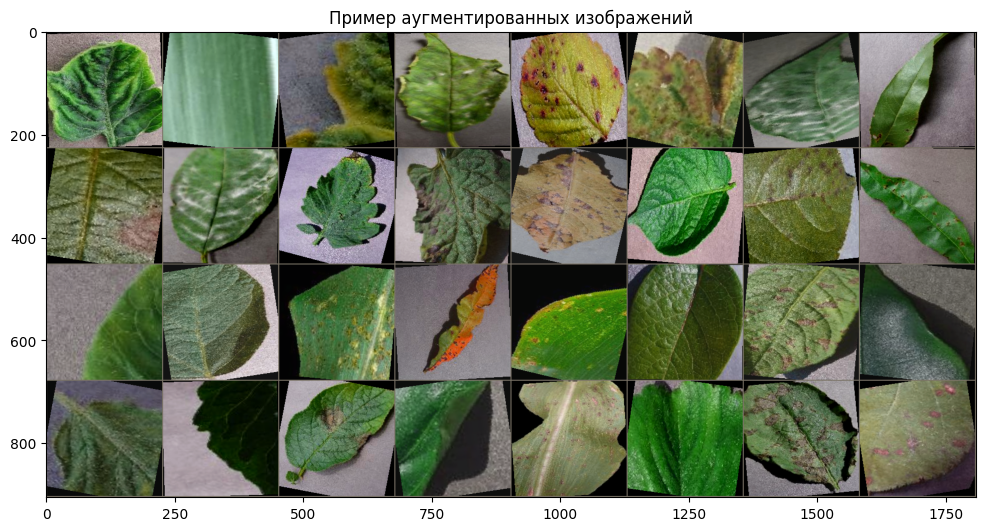

In [ ]:
def imshow(inp, title=None):
    """Функция для отображения тензора как изображения"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean 
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

class_names = train_dataset.classes
titles = [class_names[x] for x in classes]

plt.figure(figsize=(12, 8))
imshow(out, title="Пример аугментированных изображений")

##  Создание и настройка модели

Возьмем готовую, мощную нейросеть, которая уже умеет "видеть", и немного адаптируем ее для нашей задачи диагностики листьев.
Выберем ResNet50 как надежный, мощный и проверенный стандарт индустрии

In [19]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\79104/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:13<00:00, 7.49MB/s]


Заморозим все веса в модели и заменим последний слой

In [20]:
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

Определяем функцию потерь и оптимизатор

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=1e-2)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',      
    factor=0.1,      
    patience=3     
)
print("Архитектура модели после изменений:", end='\n\n')
print(model)

Архитектура модели после изменений:

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64,

##  Цикл обучения и валидации

Создадим функцию для обучения модели

In [ ]:
def train_model(model, criterion,  optimizer, scheduler, num_epochs=10):
    start_time = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Эпоха {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for  phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = valid_loader
            
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloader, desc=f'{phase.capitalize()} Phase'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            current_lr = optimizer.param_groups[0]['lr']

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} LR: {current_lr:.6f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                scheduler.step(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - start_time
    print(f'Обучение завершено за {time_elapsed // 60:.0f}м {time_elapsed % 60:.0f}с')
    print(f'Лучшая точность на валидации: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

In [31]:
num_epochs_to_train = 10
model_ft, history = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs_to_train)

torch.save(model_ft.state_dict(), 'best_plant_disease_model.pth')

Эпоха 1/10
----------


Train Phase:   0%|          | 0/2197 [00:00<?, ?it/s]

Train Loss: 1.4844 Acc: 0.7056


Val Phase:   0%|          | 0/550 [00:00<?, ?it/s]

Val Loss: 1.2288 Acc: 0.8009

Эпоха 2/10
----------


Train Phase:   0%|          | 0/2197 [00:00<?, ?it/s]

Train Loss: 1.2653 Acc: 0.7467


Val Phase:   0%|          | 0/550 [00:00<?, ?it/s]

Val Loss: 1.2081 Acc: 0.8289

Эпоха 3/10
----------


Train Phase:   0%|          | 0/2197 [00:00<?, ?it/s]

Train Loss: 1.2636 Acc: 0.7464


Val Phase:   0%|          | 0/550 [00:00<?, ?it/s]

Val Loss: 1.1837 Acc: 0.8268

Эпоха 4/10
----------


Train Phase:   0%|          | 0/2197 [00:00<?, ?it/s]

Train Loss: 1.2597 Acc: 0.7486


Val Phase:   0%|          | 0/550 [00:00<?, ?it/s]

Val Loss: 1.1797 Acc: 0.8242

Эпоха 5/10
----------


Train Phase:   0%|          | 0/2197 [00:00<?, ?it/s]

Train Loss: 1.2623 Acc: 0.7485


Val Phase:   0%|          | 0/550 [00:00<?, ?it/s]

Val Loss: 1.1787 Acc: 0.8185

Эпоха 6/10
----------


Train Phase:   0%|          | 0/2197 [00:00<?, ?it/s]

Train Loss: 1.2643 Acc: 0.7472


Val Phase:   0%|          | 0/550 [00:00<?, ?it/s]

Val Loss: 1.2143 Acc: 0.8078

Эпоха 7/10
----------


Train Phase:   0%|          | 0/2197 [00:00<?, ?it/s]

Train Loss: 1.2630 Acc: 0.7463


Val Phase:   0%|          | 0/550 [00:00<?, ?it/s]

Val Loss: 1.2010 Acc: 0.8108

Эпоха 8/10
----------


Train Phase:   0%|          | 0/2197 [00:00<?, ?it/s]

Train Loss: 1.2690 Acc: 0.7473


Val Phase:   0%|          | 0/550 [00:00<?, ?it/s]

Val Loss: 1.1863 Acc: 0.8198

Эпоха 9/10
----------


Train Phase:   0%|          | 0/2197 [00:00<?, ?it/s]

Train Loss: 1.2652 Acc: 0.7456


Val Phase:   0%|          | 0/550 [00:00<?, ?it/s]

Val Loss: 1.1819 Acc: 0.8338

Эпоха 10/10
----------


Train Phase:   0%|          | 0/2197 [00:00<?, ?it/s]

Train Loss: 1.2333 Acc: 0.7674


Val Phase:   0%|          | 0/550 [00:00<?, ?it/s]

Val Loss: 1.1804 Acc: 0.8329

Обучение завершено за 34м 2с
Лучшая точность на валидации: 0.833827


Построим графики accuracy и loss модели на тренировочных и валидационных данных

In [33]:
acc = history['train_acc']
val_acc = history['val_acc']
loss = history['train_loss']
val_loss = history['val_loss']

epochs_range =  range(num_epochs_to_train)

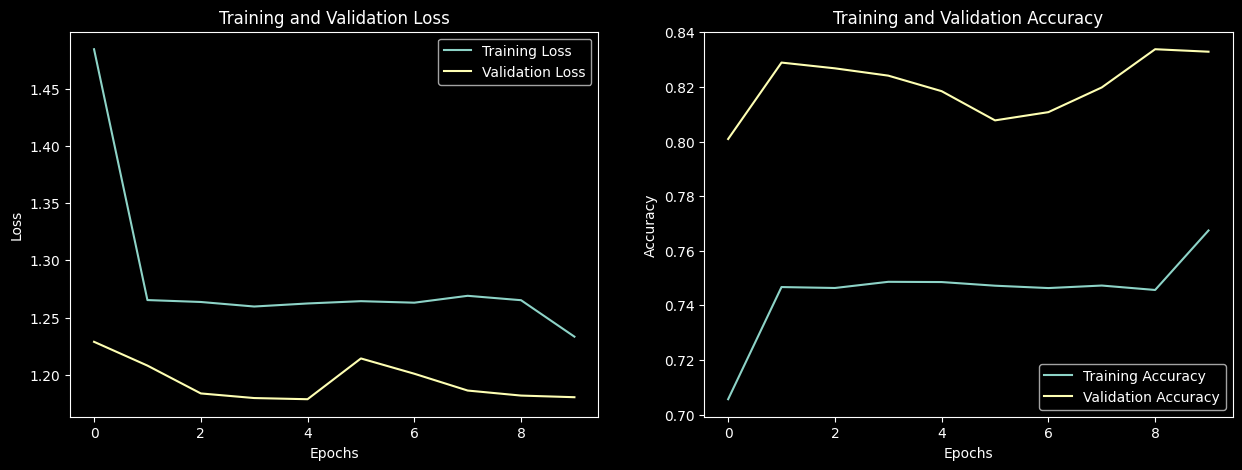

In [36]:
plt.figure(figsize=(15, 5))

# График потерь (Loss)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# График точности (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

Модель долгое время находилась на плато, но после 8 эпохи уменьшил learning rate, что привело к повышению точности. Возможно, стоит увеличить количество эпох, однако я предпочту заняться fine-tuning-ом нашей модели, чтобы "пробить" плато

## Fine-tuning

Загружаем лучшую модель с предыдущего этапа

In [37]:
# Создаем новую модель и загружаем веса (не просто присваиваем ссылку)
model_ft = models.resnet50(weights=None)  # Создаем модель без предобученных весов
num_ftrs = model_ft.fc.in_features
num_classes = len(train_dataset.classes)
model_ft.fc = nn.Linear(num_ftrs, num_classes)  # Заменяем последний слой
model_ft.load_state_dict(torch.load('best_plant_disease_model.pth'))  # Загружаем сохраненные веса
model_ft = model_ft.to(device)

Размораживаем параметры для fine-tuning

In [38]:
params_to_unfreeze = []
for name, param in model_ft.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
        params_to_unfreeze.append(param)
    else:
        param.requires_grad = False

 Создаем новый оптимизатор с разными lr для разных слоев

In [39]:
params_to_update = [
    {'params': model_ft.fc.parameters(), 'lr': 1e-4},
    {'params': model_ft.layer4.parameters(), 'lr': 1e-5}
]
optimizer_ft = optim.AdamW(params_to_update, weight_decay=1e-2)
scheduler_ft = ReduceLROnPlateau(
    optimizer_ft,
    mode='min',
    factor=0.1,
    patience=2
)

Выведем информацию о том, сколько параметров мы теперь обучаем

In [40]:
total_params = sum(p.numel() for p in model_ft.parameters())
trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f"\nВсего параметров в модели: {total_params}")
print(f"Обучаемых параметров после разморозки: {trainable_params}")


Всего параметров в модели: 23585894
Обучаемых параметров после разморозки: 15042598


Запускаем обучение еще на несколько эпох

In [ ]:
print("\n--- НАЧАЛО ЭТАПА FINE-TUNING ---")
num_epochs_finetune = 10
model_ft, history_ft = train_model(
    model_ft,
    criterion,
    optimizer_ft,
    scheduler_ft,
    num_epochs=num_epochs_finetune
)


--- НАЧАЛО ЭТАПА FINE-TUNING ---
Эпоха 1/10
----------


Train Phase:   0%|          | 0/2197 [00:00<?, ?it/s]

Train Loss: 0.6378 Acc: 0.8264


Val Phase:   0%|          | 0/550 [00:00<?, ?it/s]

Val Loss: 0.2162 Acc: 0.9380

Эпоха 2/10
----------


Train Phase:   0%|          | 0/2197 [00:00<?, ?it/s]

Train Loss: 0.3881 Acc: 0.8841


Val Phase:   0%|          | 0/550 [00:00<?, ?it/s]

Val Loss: 0.1403 Acc: 0.9577

Эпоха 3/10
----------


Train Phase:   0%|          | 0/2197 [00:00<?, ?it/s]

Train Loss: 0.3075 Acc: 0.9075


Val Phase:   0%|          | 0/550 [00:00<?, ?it/s]

Val Loss: 0.0960 Acc: 0.9710

Эпоха 4/10
----------


Train Phase:   0%|          | 0/2197 [00:00<?, ?it/s]

Train Loss: 0.2612 Acc: 0.9193


Val Phase:   0%|          | 0/550 [00:00<?, ?it/s]

Val Loss: 0.0845 Acc: 0.9730

Эпоха 5/10
----------


Train Phase:   0%|          | 0/2197 [00:00<?, ?it/s]

Train Loss: 0.2252 Acc: 0.9300


Val Phase:   0%|          | 0/550 [00:00<?, ?it/s]

Val Loss: 0.0662 Acc: 0.9790

Эпоха 6/10
----------


Train Phase:   0%|          | 0/2197 [00:00<?, ?it/s]

Train Loss: 0.2055 Acc: 0.9354


Val Phase:   0%|          | 0/550 [00:00<?, ?it/s]

Val Loss: 0.0631 Acc: 0.9796

Эпоха 7/10
----------


Train Phase:   0%|          | 0/2197 [00:00<?, ?it/s]

Train Loss: 0.1820 Acc: 0.9436


Val Phase:   0%|          | 0/550 [00:00<?, ?it/s]

Val Loss: 0.0502 Acc: 0.9836

Эпоха 8/10
----------


Train Phase:   0%|          | 0/2197 [00:00<?, ?it/s]

Train Loss: 0.1755 Acc: 0.9440


Val Phase:   0%|          | 0/550 [00:00<?, ?it/s]

Val Loss: 0.0454 Acc: 0.9857

Эпоха 9/10
----------


Train Phase:   0%|          | 0/2197 [00:00<?, ?it/s]

Train Loss: 0.1613 Acc: 0.9486


Val Phase:   0%|          | 0/550 [00:00<?, ?it/s]

Val Loss: 0.0431 Acc: 0.9861

Эпоха 10/10
----------


Train Phase:   0%|          | 0/2197 [00:00<?, ?it/s]

Train Loss: 0.1507 Acc: 0.9526


Val Phase:   0%|          | 0/550 [00:00<?, ?it/s]

Val Loss: 0.0368 Acc: 0.9887

Обучение завершено за 38м 32с
Лучшая точность на валидации: 0.988675


Идеально! Наша модель может предсказывать класс объекта практически с идеальной точностью **99%**

Сохраняем финальную, дообученную модель


In [44]:
torch.save(model_ft.state_dict(), 'finetuned_plant_disease_model.pth')

Визуализируем графики второго этапа обучения модели

In [47]:
# Исправлено: используем history_ft вместо history для корректной визуализации fine-tuning
acc_ft = history_ft['train_acc']
val_acc_ft = history_ft['val_acc']
loss_ft = history_ft['train_loss']
val_loss_ft = history_ft['val_loss']

epochs_range_ft = range(num_epochs_finetune)

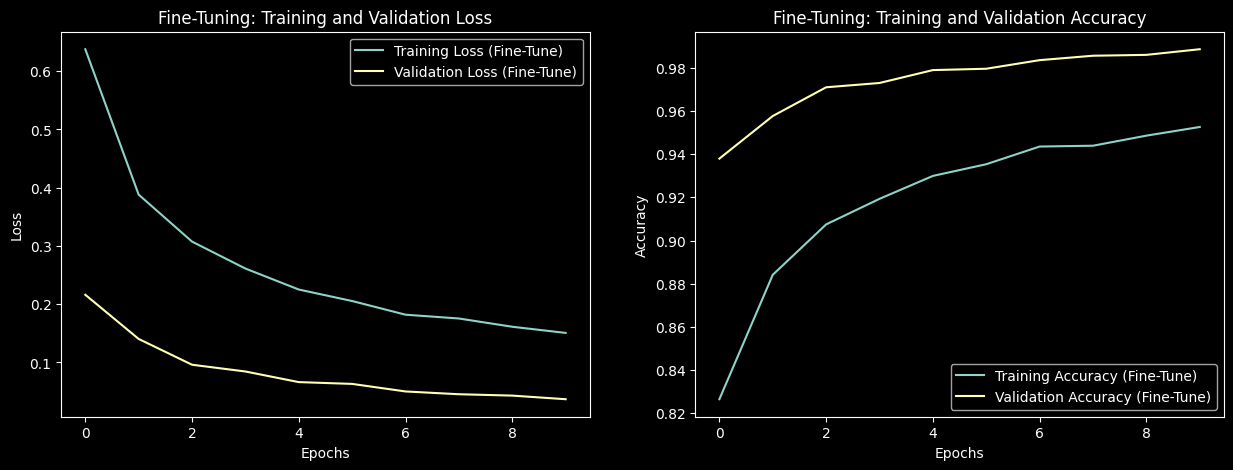

In [48]:
plt.figure(figsize=(15, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(epochs_range_ft, loss_ft, label='Training Loss (Fine-Tune)')
plt.plot(epochs_range_ft, val_loss_ft, label='Validation Loss (Fine-Tune)')
plt.legend(loc='upper right')
plt.title('Fine-Tuning: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs_range_ft, acc_ft, label='Training Accuracy (Fine-Tune)')
plt.plot(epochs_range_ft, val_acc_ft, label='Validation Accuracy (Fine-Tune)')
plt.legend(loc='lower right')
plt.title('Fine-Tuning: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

Отичный результат! Метрика и лосс на тренировке меньше, чем на валидации из-за аугментации, так что никаких проблем в процессе обучения модели не возникло: loss уменьшался, accuracy увеличивалась. Большее количество эпох привело бы к ещё более идеальной модели, но мне достаточно и такой точности